# Data Preprocessing
## Introduction
This notebook focuses on loading the raw data, performing initial data cleaning, eventually creating a processed_data csv.

### Folder Structure & File Handling
To make this process replicable, create two folders in the `data` directory: one titled `raw` and the other titled `processed`.
The initial function loads the data from the `raw` data folder. This file is kept in the `.gitignore` to prevent it from being tracked in version control. The file paths in this script and the rest of the notebooks should then work seamlessly.
The file paths in this script and the rest of the notebooks should then work. 

### Data Cleaning 
This initial script checks for null values in both of the raw columns provided: `signal` and `equity_curve`. To determine the success of the signals, a third column, `equity_return`, is created at this stage. It represents the percentage return of the next day's equity value compared to the current day's.

### Avoiding Look-Ahead Bias
To prevent look-ahead bias, the `equity_return` column will be removed from the test data once the data is separated. However, this column is necessary at this stage to understand the signals.

### Removing Incomplete Records
The script also removes the final record in the data, as it will not have a corresponding next day's equity value for comparison.

### Saving Processed Data
The final part of this script saves the preprocessed data to a CSV file in the `data/processed/` folder for other notebooks to ingest and use.

In [ ]:
import pandas as pd

In [275]:
def load_and_preprocess_data(file_path):
    data = pd.read_csv(file_path)

    data['signal'] = pd.to_numeric(data['signal'], errors='coerce')
    data['equity_curve'] = pd.to_numeric(data['equity_curve'], errors='coerce')

    null_signals = data['signal'].isna().sum()
    null_equity_curve = data['equity_curve'].isna().sum()

    print(f"Number of null values in 'signal': {null_signals}")
    print(f"Number of null values in 'equity_curve': {null_equity_curve}")

    data = data.dropna()

    data['equity_returns'] = data['equity_curve'].pct_change().shift(-1)

    data = data.dropna()
    data = data[:-1]

    return data

file_path = "../data/raw/sovereign_quant_developer_assignment_data.csv"
data = load_and_preprocess_data(file_path)

processed_file_path = "../data/processed/processed_data.csv"
data.to_csv(processed_file_path, index = False)

data.info()


Number of null values in 'signal': 0
Number of null values in 'equity_curve': 0
<class 'pandas.core.frame.DataFrame'>
Index: 49996 entries, 0 to 49995
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      49996 non-null  int64  
 1   signal          49996 non-null  float64
 2   equity_curve    49996 non-null  float64
 3   equity_returns  49996 non-null  float64
dtypes: float64(3), int64(1)
memory usage: 1.9 MB


In [269]:
train_size = int(0.8 * len(data))
train_df = data[:train_size]
test_df = data[train_size:]

quantiles = np.linspace(0, 1, 14)  # 10 quantiles
train_df['signal_group'] = pd.qcut(data['signal'], quantiles, labels=False)
group_returns = train_df.groupby('signal_group')['equity_returns'].mean()
train_df['cumulative_returns'] = train_df.groupby('signal_group')['equity_returns'].cumsum()

# Get the summary statistics for each signal group
group_summary = train_df.groupby('signal_group').agg({
    'signal': ['min', 'max', 'mean'],
    'equity_returns': ['mean', 'std', 'count'],
    'cumulative_returns': ['last']
})

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

print(group_summary)

                signal                     equity_returns                  \
                   min       max      mean           mean       std count   
signal_group                                                                
0            -0.041569 -0.014062 -0.018513      -0.000348  0.010253  3059   
1            -0.014062 -0.010112 -0.011931      -0.000103  0.009913  3083   
2            -0.010110 -0.007359 -0.008667      -0.000281  0.010247  3097   
3            -0.007359 -0.005094 -0.006204      -0.000244  0.010061  3065   
4            -0.005092 -0.003014 -0.004040      -0.000149  0.010238  3089   
5            -0.003014 -0.001122 -0.002072      -0.000023  0.010130  3075   
6            -0.001122  0.000769 -0.000168       0.000422  0.010005  3081   
7             0.000769  0.002641  0.001703       0.000262  0.009669  3072   
8             0.002642  0.004722  0.003667      -0.000172  0.009913  3071   
9             0.004722  0.007036  0.005854       0.000339  0.009779  3133   

/var/folders/q4/qlhh3zds71n242024cd1plqr0000gn/T/ipykernel_13701/2713882846.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['signal_group'] = pd.qcut(data['signal'], quantiles, labels=False)
/var/folders/q4/qlhh3zds71n242024cd1plqr0000gn/T/ipykernel_13701/2713882846.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['cumulative_returns'] = train_df.groupby('signal_group')['equity_returns'].cumsum()


In [251]:
quantiles = np.linspace(0, 1, 11)  # 10 quantiles

# Assign group numbers to each record
data['signal_group'] = pd.qcut(data['signal'], quantiles, labels=False)

# Calculate the mean returns for each group
group_returns = data.groupby('signal_group')['equity_returns'].mean()

data['cumulative_returns'] = data.groupby('signal_group')['equity_returns'].cumsum()

# Get the summary statistics for each signal group
group_summary = data.groupby('signal_group').agg({
    'signal': ['min', 'max', 'mean'],
    'equity_returns': ['mean', 'std', 'count'],
    'cumulative_returns': ['last']
})

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

print(group_summary)
group_summary.to_csv('group_summary.csv')


                signal                     equity_returns                  \
                   min       max      mean           mean       std count   
signal_group                                                                
0            -0.041569 -0.012695 -0.017328      -0.000416  0.010262  5000   
1            -0.012694 -0.008357 -0.010354      -0.000210  0.010068  5000   
2            -0.008356 -0.005318 -0.006795      -0.000178  0.010134  4999   
3            -0.005318 -0.002629 -0.003938      -0.000040  0.010059  5000   
4            -0.002628 -0.000171 -0.001398       0.000046  0.010152  5000   
5            -0.000171  0.002278  0.001046       0.000334  0.009849  4999   
6             0.002279  0.004933  0.003571      -0.000097  0.009873  5000   
7             0.004934  0.008073  0.006450       0.000419  0.009725  4999   
8             0.008073  0.012408  0.010073       0.000229  0.009837  5000   
9             0.012409  0.037203  0.017160       0.000450  0.009731  5000   

In [ ]:
train_size = int(0.8 * len(data))
train_df = data[:train_size]
test_df = data[train_size:]

def quantile_strategy(test_data, training_data):
    quantiles = np.linspace(0, 1, 11)  # 10 quantiles
    train_df['signal_group'] = pd.qcut(data['signal'], quantiles, labels=False)

In [252]:
buy_groups = [7, 8, 9]
sell_groups = [0, 1, 2]

data['trade_signal'] = 0
data.loc[data['signal_group'].isin(buy_groups), 'trade_signal'] = 1
data.loc[data['signal_group'].isin(sell_groups), 'trade_signal'] = -1

print(data[['signal', 'signal_group', 'trade_signal', 'equity_returns']].head(20))




      signal  signal_group  trade_signal  equity_returns
0  -0.023860             0            -1       -0.009910
1  -0.010445             1            -1        0.006960
2  -0.007646             2            -1       -0.004174
3  -0.000148             5             0       -0.015721
4  -0.011530             1            -1       -0.006456
5   0.004612             6             0        0.006004
6  -0.011611             1            -1        0.003328
7  -0.007723             2            -1       -0.011409
8  -0.008583             1            -1        0.006206
9   0.007786             7             1       -0.000879
10  0.018747             9             1        0.004260
11 -0.014040             0            -1        0.003328
12  0.001979             5             0       -0.011502
13 -0.004631             3             0        0.003516
14 -0.011501             1            -1       -0.006050
15 -0.011793             1            -1        0.015590
16 -0.025271             0     

In [263]:
data['strategy_returns'] = data['equity_returns'] * data['trade_signal']
data['strategy_returns'].replace({0: np.nan, -0.0: np.nan}, inplace=True)

not_null_trades = data['strategy_returns'].notna().sum()
positive_non_null_trade_count = data['strategy_returns'][data['strategy_returns'] > 0].notna().sum()
win_percentage = positive_non_null_trade_count / not_null_trades

print(f'not null {not_null_trades}')
print(f'positive {positive_non_null_trade_count}')
print(f'win percentage {win_percentage}')

print(data[['signal', 'signal_group', 'trade_signal', 'equity_returns', 'strategy_returns']].head(20))


not null 29998
positive 15330
win percentage 0.5110340689379292
      signal  signal_group  trade_signal  equity_returns  strategy_returns
0  -0.023860             0            -1       -0.009910          0.009910
1  -0.010445             1            -1        0.006960         -0.006960
2  -0.007646             2            -1       -0.004174          0.004174
3  -0.000148             5             0       -0.015721               NaN
4  -0.011530             1            -1       -0.006456          0.006456
5   0.004612             6             0        0.006004               NaN
6  -0.011611             1            -1        0.003328         -0.003328
7  -0.007723             2            -1       -0.011409          0.011409
8  -0.008583             1            -1        0.006206         -0.006206
9   0.007786             7             1       -0.000879         -0.000879
10  0.018747             9             1        0.004260          0.004260
11 -0.014040             0          

/var/folders/q4/qlhh3zds71n242024cd1plqr0000gn/T/ipykernel_13701/3967778937.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['strategy_returns'].replace({0: np.nan, -0.0: np.nan}, inplace=True)


   trade_signal  equity_returns  strategy_returns  cumulative_strategy_returns
0            -1       -0.009910          0.009910                     1.009910
1            -1        0.006960         -0.006960                     1.002881
2            -1       -0.004174          0.004174                     1.007067
3             0       -0.015721         -0.000000                     1.007067
4            -1       -0.006456          0.006456                     1.013569
5             0        0.006004          0.000000                     1.013569
6            -1        0.003328         -0.003328                     1.010195
7            -1       -0.011409          0.011409                     1.021721
8            -1        0.006206         -0.006206                     1.015380
9             1       -0.000879         -0.000879                     1.014487


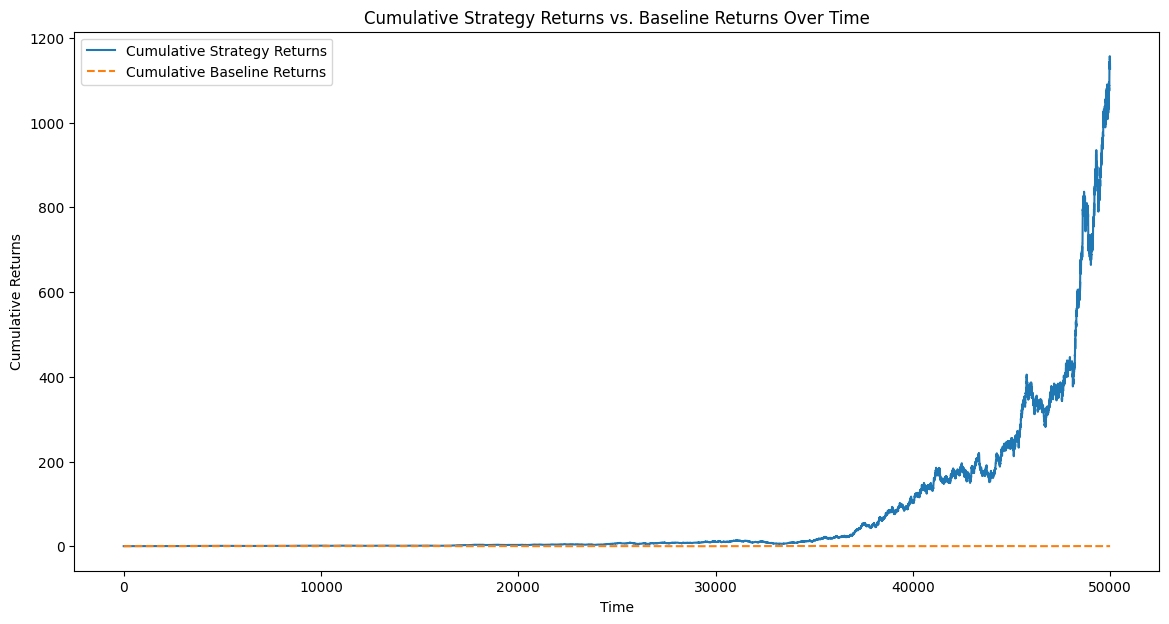

Expected Cumulative Return based on Equity Curve: 0.2047
Calculated Cumulative Return from Strategy Returns: 1126.4318


In [259]:
# Calculate returns based on trade signals




print(data[['signal', 'signal_group', 'trade_signal', 'equity_returns']].head(20))

# Calculate cumulative returns
data['cumulative_strategy_returns'] = (1 + data['strategy_returns']).cumprod()
data['cumulative_baseline_returns'] = (1 + data['equity_returns']).cumprod()

initial_value = data['equity_curve'].iloc[0]
data['normalized_cumulative_strategy_returns'] = initial_value * data['cumulative_strategy_returns']
data['normalized_cumulative_baseline_returns'] = initial_value * data['cumulative_baseline_returns']

print(data[['trade_signal', 'equity_returns', 'strategy_returns', 'cumulative_strategy_returns']].head(10))


plt.figure(figsize=(14, 7))
plt.plot(data['normalized_cumulative_strategy_returns'], label='Cumulative Strategy Returns')
plt.plot(data['normalized_cumulative_baseline_returns'], label='Cumulative Baseline Returns', linestyle='--')
plt.title('Cumulative Strategy Returns vs. Baseline Returns Over Time')
plt.xlabel('Time')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()


start_value = data['equity_curve'].iloc[0]
end_value = data['equity_curve'].iloc[-1]
expected_cumulative_return = (end_value - start_value) / start_value
print(f'Expected Cumulative Return based on Equity Curve: {expected_cumulative_return:.4f}')

final_cumulative_return = data['normalized_cumulative_strategy_returns'].iloc[-1] - 1
print(f'Calculated Cumulative Return from Strategy Returns: {final_cumulative_return:.4f}')


Correlation between signals and returns: 0.023605245018624085


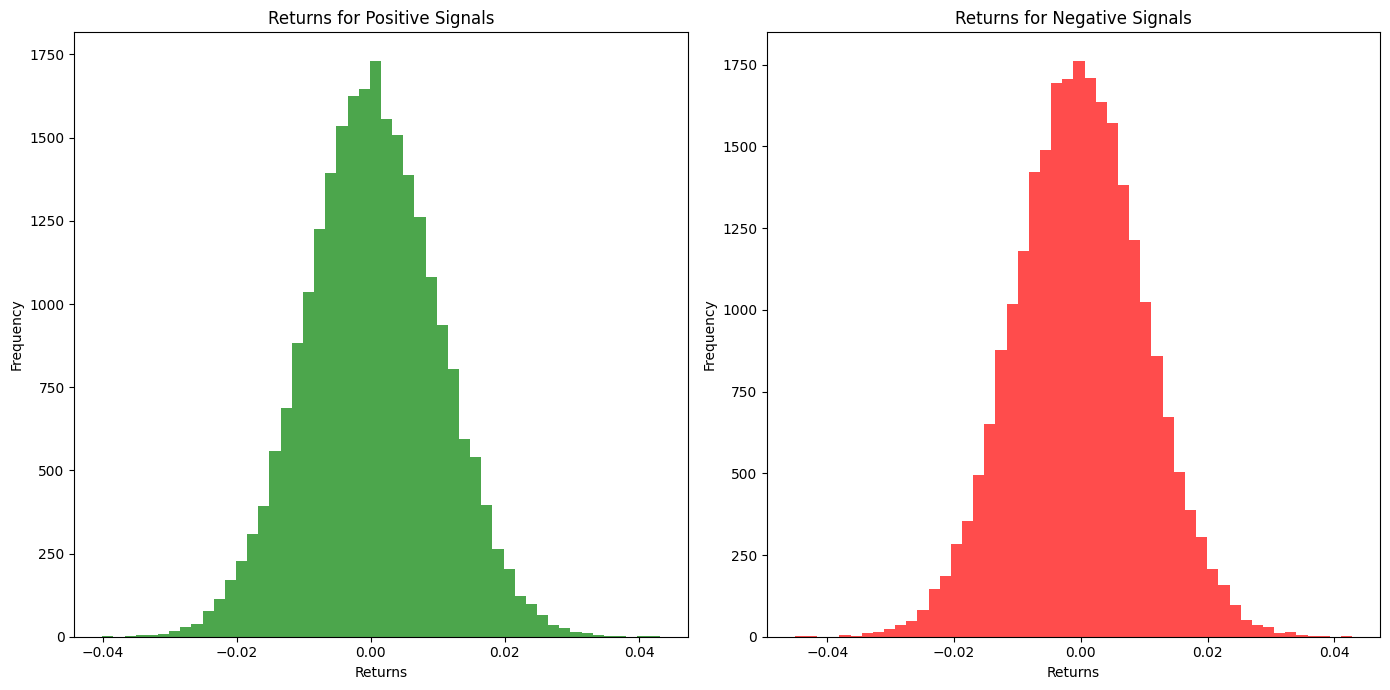

In [271]:
# Calculate correlation between signals and returns
correlation = data['signal'].corr(data['equity_returns'])
print(f"Correlation between signals and returns: {correlation}")

# Analyze distribution of returns for positive and negative signals
positive_signals = data[data['signal'] > 0]['equity_returns']
negative_signals = data[data['signal'] < 0]['equity_returns']

# Plot histograms
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.hist(positive_signals, bins=50, color='green', alpha=0.7)
plt.title('Returns for Positive Signals')
plt.xlabel('Returns')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(negative_signals, bins=50, color='red', alpha=0.7)
plt.title('Returns for Negative Signals')
plt.xlabel('Returns')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import ttest_1samp

# Perform t-test for positive signals
t_stat_pos, p_val_pos = ttest_1samp(positive_signals, 0)
print(f"T-Test for Positive Signals: t-statistic = {t_stat_pos}, p-value = {p_val_pos}")

# Perform t-test for negative signals
t_stat_neg, p_val_neg = ttest_1samp(negative_signals, 0)
print(f"T-Test for Negative Signals: t-statistic = {t_stat_neg}, p-value = {p_val_neg}")


Cumulative Return: 3046.8523
Average Return: 0.0003
Standard Deviation: 0.0100
Sharpe Ratio: 9.9782
Max Drawdown: -0.5696
Win Percentage: 51.1034


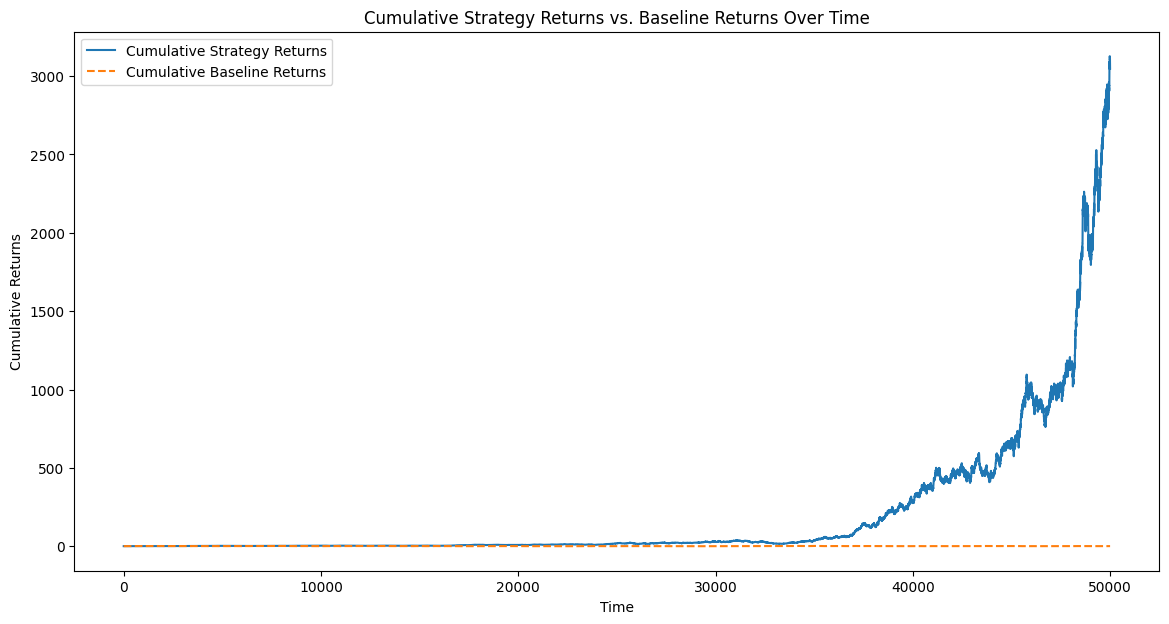

In [257]:
def calculate_trading_statistics(data):
    returns = data['strategy_returns']
    cumulative_returns = data['cumulative_strategy_returns']

    cumulative_return = cumulative_returns.iloc[-1] - 1

    traded_returns = data[data['trade_signal'] != 0]['strategy_returns']
    avg_return = traded_returns.mean()

    std_dev = traded_returns.std()

    # Assuming this is minute data for determining sharp ratio

    sharpe_ratio = avg_return / std_dev * np.sqrt(98280)

    cumulative_returns_plus_one = cumulative_returns + 1
    drawdown = cumulative_returns_plus_one / cumulative_returns_plus_one.cummax() - 1
    max_drawdown = drawdown.min()

    num_wins = np.sum(traded_returns > 0)
    num_trades = len(traded_returns)
    win_percentage = num_wins / num_trades * 100

    return {
        'Cumulative Return': cumulative_return,
        'Average Return': avg_return,
        'Standard Deviation': std_dev,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown,
        'Win Percentage': win_percentage
    }

trading_stats = calculate_trading_statistics(data)

for stat, value in trading_stats.items():
    print(f'{stat}: {value:.4f}')

plt.figure(figsize=(14, 7))
plt.plot(data['cumulative_strategy_returns'], label='Cumulative Strategy Returns')
plt.plot(data['cumulative_baseline_returns'], label='Cumulative Baseline Returns', linestyle='--')
plt.title('Cumulative Strategy Returns vs. Baseline Returns Over Time')
plt.xlabel('Time')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

